Este jupyter notebook es de autoría de Pedro Salinas Hermosilla para entrar Data Scientist en LATAM.

Las variables del problema estás en el PDF adjunto junto con la data que fue proporcionada por LATAM.

# Paso 0: Librerías y data

## Importamos las librerías

Considerando que el codigo se correrá de una vez, se agruparán todas las librerías dentro de este paso. El python utilizado es el Python 3.10.8

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import xgboost as xgb

## Extraemos los datos

In [2]:
data = pd.read_csv("dataset_SCL.csv", low_memory = False)

Luego de la extracción, se verifican si existen datos nulos. En caso de existir se evaluará caso a caso que se puede hacer con ellos.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB


Como se comprueba en la linea anterior, no existen datos nulos dentro de la base de datos. Con esto realizado procederemos a ver la distribución de la data.

# Paso 1: Distribución de la Data

Para ver la distribución de la data se realizarán diferentes lineas de codigo, las cuales se irán explicando que se hizo en cada una y que se puede sacar de esta misma. Finalmente existe una sección de "Conclusiones de la data" donde están agrupadas las conclusiones principales extraidas del set de datos, teniendo siempre clara la visión de negocios dentro del análisis.

## Información en Tablas

In [4]:
for col in data.columns:
    print(col, data[col].nunique())

Fecha-I 53252
Vlo-I 584
Ori-I 1
Des-I 64
Emp-I 30
Fecha-O 62774
Vlo-O 861
Ori-O 1
Des-O 63
Emp-O 32
DIA 31
MES 12
AÑO 2
DIANOM 7
TIPOVUELO 2
OPERA 23
SIGLAORI 1
SIGLADES 62


Con esta información, vemos que tan dispersa es la data dentro de si misma. Es decir cuantos campos diferentes encontrariamos dentro de una misma columna.

Al visualizar esta información, hace sentido el uso de Python para el trabajo de la data. Dado que un excel quedaría "corto" y no sería lo optimo para el desempeño de las labores.

Tambien se puede ver que la columna Ori-I y Ori-O tienen solamente 1 valor. 

In [5]:
freq = pd.crosstab(index=data['SIGLADES'], columns='count')
freq = freq.sort_values('count', ascending=False)
print(freq)

col_0             count
SIGLADES               
Buenos Aires       6335
Antofagasta        5786
Lima               5270
Calama             5146
Puerto Montt       4357
...                 ...
Cataratas Iguacu      2
Pisco, Peru           1
Puerto Stanley        1
Cochabamba            1
Washington            1

[62 rows x 1 columns]


Con esta información, tenemos los destinos favoritos de las aerolineas.

In [6]:
Opera_Vuelo = data.groupby(['OPERA','TIPOVUELO']).size().reset_index(name='count')
Opera_Vuelo = Opera_Vuelo.sort_values('count', ascending=False)
print(Opera_Vuelo.to_string(index=False))

                   OPERA TIPOVUELO  count
             Grupo LATAM         N  23743
             Grupo LATAM         I  17149
             Sky Airline         N  11498
             Sky Airline         I   2800
   Aerolineas Argentinas         I   1949
                Copa Air         I   1850
                 Avianca         I   1152
            JetSmart SPA         N   1089
    Latin American Wings         I   1038
               Gol Trans         I    806
       American Airlines         I    757
    Latin American Wings         N    636
              Air Canada         I    565
                  Iberia         I    362
               Delta Air         I    358
              Air France         I    358
              Aeromexico         I    351
         United Airlines         I    335
  Oceanair Linhas Aereas         I    279
                Alitalia         I    259
                  K.L.M.         I    251
         British Airways         I    205
          Qantas Airways         I

De esta tabla agregada, se puede ver la superioridad en cantidad de vuelos de LAN y SKY versus el resto de los competidores, esto filtrando por tipo de vuelo Nacional o Internacional.

Tambien sirve para ver que empresas como JetSmart y LAW están empezando a entrar dentro del mercado de vuelos nacionales, el cual es dominado por LAN y seguido por SKY.

In [7]:
tabla_prog_opera = pd.crosstab(data['Emp-I'], data['Emp-O'])
print(tabla_prog_opera)

Emp-O  48O  56R  AAL  ACA  AFR  AMX   ARG  AUT  AVA  AZA  ...   LPE  LRC  \
Emp-I                                                     ...              
AAL      0    0  757    0    0    0     0    0    0    0  ...     0    0   
ACA      0    0    0  565    0    0     0    0    0    0  ...     0    0   
AFR      0    0    0    0  358    0     0    0    0    0  ...     0    0   
AMX      0    0    0    0    0  351     0    0    0    0  ...     0    0   
ARG      0    0    0    0    0    0  1944    5    0    0  ...     0    0   
AUT      0    0    0    0    0    0     2   72    0    0  ...     0    0   
AVA      0    0    0    0    0    0     0    0  885    0  ...     0  265   
AZA      0    0    0    0    0    0     0    0    0  259  ...     0    0   
BAW      0    0    0    0    0    0     0    0    0    0  ...     0    0   
CMP      0    0    0    0    0    0     0    0    0    0  ...     0    0   
DAL      0    0    0    0    0    0     0    0    0    0  ...     0    0   
DSM      0  

Esta tabla sirve para visualizar los vuelos programados versus realmente quien los ejecutó.

In [8]:
tabla_prog_opera['LXP']

Emp-I
AAL        0
ACA        0
AFR        0
AMX        0
ARG        0
AUT        0
AVA        0
AZA        0
BAW        0
CMP        0
DAL        0
DSM        0
GLO        0
IBE        0
JAT        0
JMR        0
KLM        0
LAN    14549
LAP        0
LAW        0
LNE        0
LPE        0
LRC        0
LXP        9
ONE        0
PUE        0
QFU        0
SKU        0
TAM        0
UAL        0
Name: LXP, dtype: int64

Al hacer un zoom en LXP, que es LAN EXPRESS, no podemos dar cuenta que 14.549 vuelos que debían ser operados por LAN son operados por LXP.

In [9]:
Opera_Vuelo = data.groupby(['Emp-O','TIPOVUELO']).size().reset_index(name='count')
Opera_Vuelo = Opera_Vuelo.sort_values('count', ascending=False)
print(Opera_Vuelo.to_string(index=False))

Emp-O TIPOVUELO  count
  LXP         N  14558
  LAN         I  11803
  SKU         N  11498
  LAN         N   9185
  TAM         I   3046
  SKU         I   2800
  ARG         I   1946
  CMP         I   1850
  LPE         I   1214
  JAT         N   1089
  JMR         I   1011
  AVA         I    885
  GLO         I    806
  AAL         I    757
  JMR         N    636
  ACA         I    565
  DSM         I    493
  LNE         I    374
  IBE         I    362
  AFR         I    358
  DAL         I    358
  LRC         I    357
  AMX         I    351
  UAL         I    335
  ONE         I    279
  AZA         I    259
  KLM         I    251
  LAP         I    219
  BAW         I    205
  QFA         I    195
  AUT         I     77
  PUE         I     49
  56R         I     17
  48O         I     10
  JAT         I      6
  TPU         I      2


Con esta información podemos ver que LXP lo utiliza LATAM para vuelos nacionales, podemos decir esto dado que LXP inicialmente tenía 9 vuelos y ocupa 14.549 vuelos de LATAM, es decir la totalidad de vuelos que tienen son del tipo nacional.

In [10]:
Opera_Vuelo_LXP = data.groupby(['Emp-O','SIGLADES']).size().reset_index(name='count')
Opera_Vuelo_LXP = Opera_Vuelo.sort_values('count', ascending=False)
for index,row in Opera_Vuelo_LXP.iterrows():
    if row['Emp-O'] != 'LXP':
        Opera_Vuelo_LXP = Opera_Vuelo_LXP.drop([index])
print(Opera_Vuelo_LXP.to_string(index=False))

Emp-O TIPOVUELO  count
  LXP         N  14558


Con esta información podemos ver cuales son los destinos que ocupa LATAM la aerolinea LXP dentro del territorio nacional.

## Crearemos gráficos para ver la data y su comportamiento

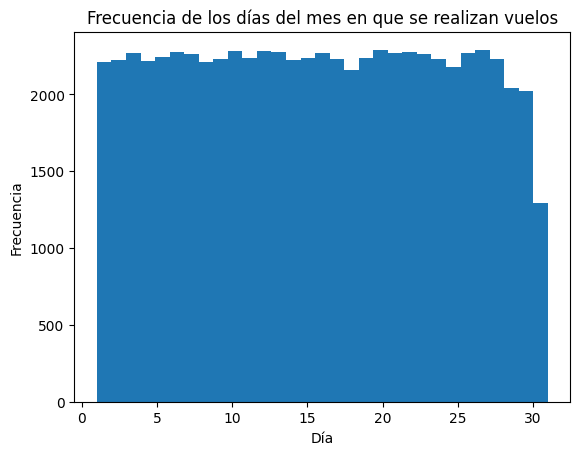

In [11]:
plt.hist(data['DIA'], bins=31)
plt.title('Frecuencia de los días del mes en que se realizan vuelos')
plt.xlabel('Día')
plt.ylabel('Frecuencia')
plt.show()

De este gráfico, se puede ver que los días que menos vuelos se realizan corresponden a los últimos 3 días, esto se puede deber a que no todos los meses tienen estos 3 días.

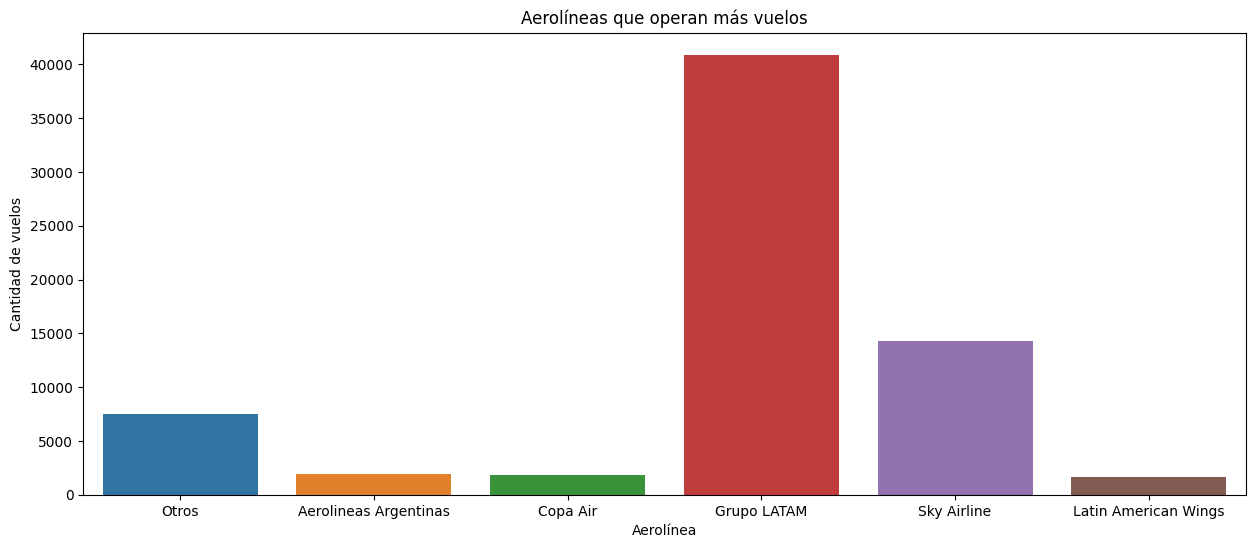

In [12]:
top_airlines = data['OPERA'].value_counts().sort_values(ascending=False).nlargest(5).index.tolist()
data['OPERA_top'] = np.where(data['OPERA'].isin(top_airlines), data['OPERA'], 'Otros')
plt.figure(figsize=(15, 6))
sns.countplot(x='OPERA_top', data=data)
plt.title('Aerolíneas que operan más vuelos')
plt.xlabel('Aerolínea')
plt.ylabel('Cantidad de vuelos')
plt.show()
data = data.drop(['OPERA_top'],axis=1)

De este gráfico, podemos ver que aerolineas son las que más tienen vuelos desde el aeropuerto de Santiago, las cuales son LAN y SKY. Dentro de este gráfico no se dimensiona la magnitud por lo que se generó el siguiente gráfico para poder visualizarlo de mejor manera.

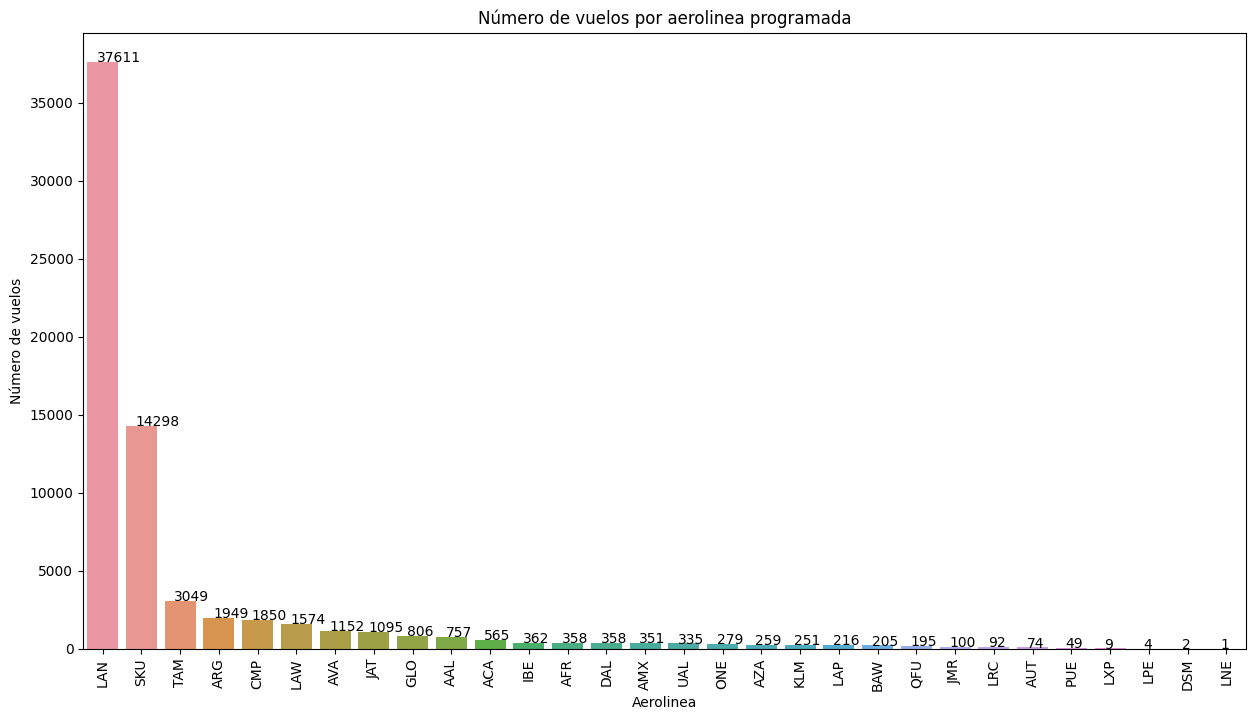

In [13]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x='Emp-I', data=data, order = data['Emp-I'].value_counts().index)
plt.title("Número de vuelos por aerolinea programada")
plt.xlabel('Aerolinea')
plt.ylabel('Número de vuelos')
plt.xticks(rotation=90)
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))


De este gráfico se puede comprobar que las magnitudes LATAM con SKY son superiores al resto en número de vuelo. Notar que se utiliza la aerolinea programada dado que esta es la inicial para la base de datos del aeropuerto. No siempre podemos saber la que realmente operará el vuelo con anticipación.

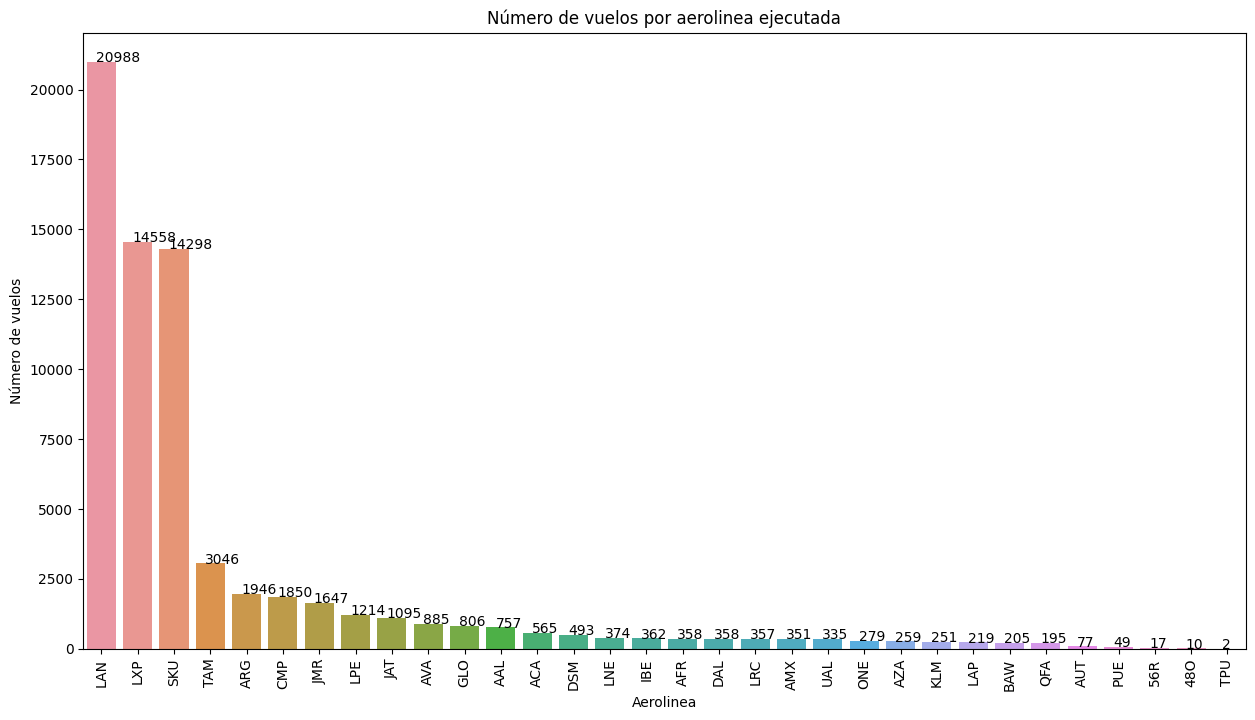

In [14]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x='Emp-O', data=data, order = data['Emp-O'].value_counts().index)
plt.title("Número de vuelos por aerolinea ejecutada")
plt.xlabel('Aerolinea')
plt.ylabel('Número de vuelos')
plt.xticks(rotation=90)
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

De este gráfico se puede ver que la aerolinea LXP aumenta mucho en la cantidad de vuelos ejecutados versus los programados.

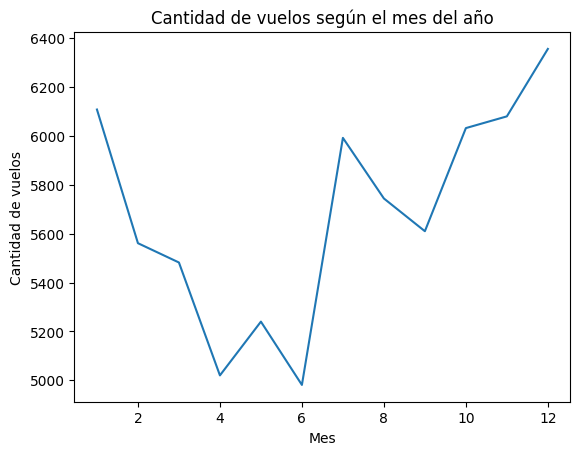

In [15]:
data_mes = data.groupby(['MES']).size().reset_index(name='count')
plt.plot(data_mes['MES'], data_mes['count'])
plt.title('Cantidad de vuelos según el mes del año')
plt.xlabel('Mes')
plt.ylabel('Cantidad de vuelos')
plt.show()

Con esta información vemos como afecta la temporalidad al número de vuelos, donde en el verano es superior al resto del año.

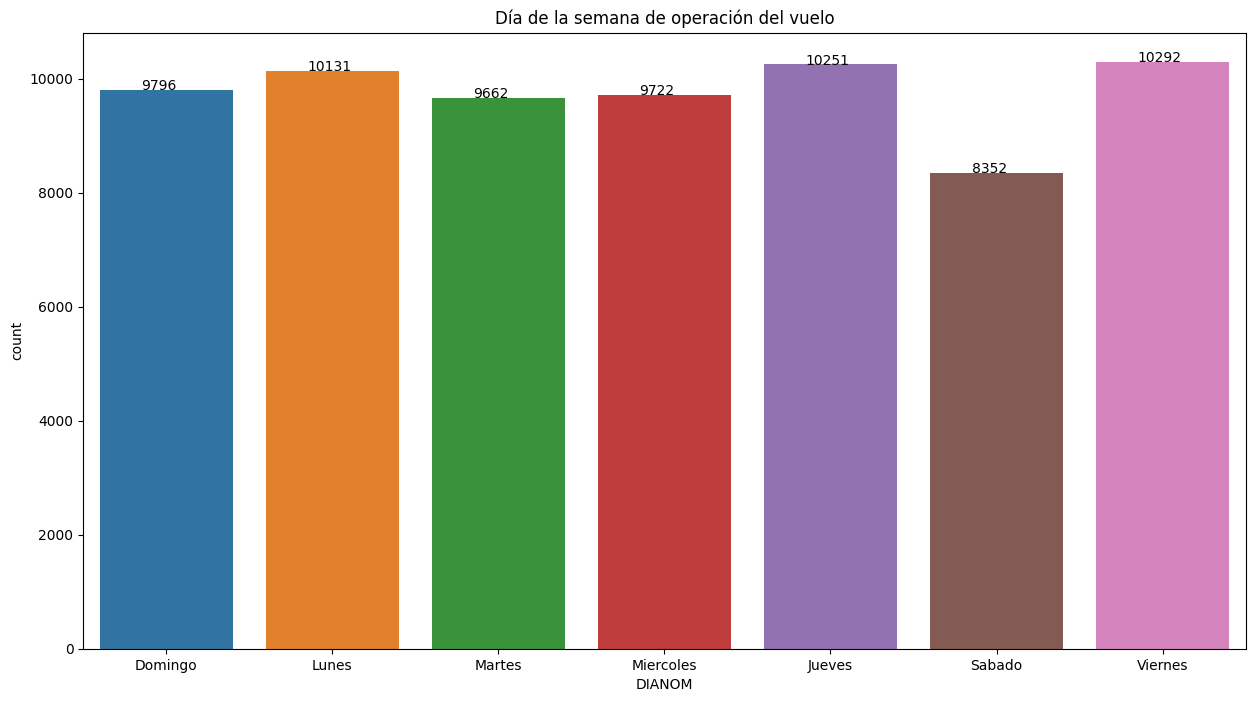

In [16]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x='DIANOM', data=data)
plt.title("Día de la semana de operación del vuelo")
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

Con este gráfico podemos decir que los días Sabados es cuando menos vuelos sales del aeropuerto de santiago a lo largo del año, mientras que los días preferidos son Lunes, Jueves y Viernes.

## Conclusiones de la data

Con toda la información extraida se puede concluir:
* En primera instancia que el aeropuerto de santiago tiene que los últimos días del mes es cuando menos frecuencia tiene el aeropuerto, esto se podría deber a la temporalidad de la situación junto a que no todos los meses tienen estos días. Los días donde menos vuelos sales del aeropuerto son los Sabados, mientras que los Lunes, Jueves y Viernes son donde más frecuencia hay de vuelos.
* Otra importante conclusión es que LAN con SKY son las empresas predominantes en el uso del aeropuerto, esto se podría deber a la cantidad de vuelos que tienen nacionales. Esto se logra ver de mejor forma cuando se ordenan por tipo de vuelo y empresa operadora la cantidad de vuelos. Donde LAN y SKY son el top 1-2 en el aeropuerto, por gran mayoría sobre el resto. Esto se puede ver en el gráfico de Empresas programadas versus número de vuelos.
* Los destinos más repetidos son Buenos Aires con Antofagasta, seguidos de Lima, Calama y Puerto Montt. Por lo que entre las 5 ciudades, 3 son nacionales lo que hace sentido en relación al punto anterior.
* Las aerolineas programadas versus las ejecutadas son diferentes, en este sentido se destaca lo de LXP que toma aproximadamente 14.500 vuelos de LATAM. Notar de igual forma que los dueños de las aerolineas son los mismos y el único cambio es nominal. El uso de LXP por parte de LATAM es únicamente para los vuelos nacionales, no realizan este cambio en los vuelos internacionales y es solamente en algunos vuelos. Estos vuelos tienen como destinos Puerto Montt, Concepción y Calama en su mayoría.
* Como última conclusión, se puede ver que las fechas de verano junto con Julio corresponden a la parte donde la gente anda más en avión, lo cual puede ser explicado por las posibles vacaciones de la gente.

# Paso 2: Agregar columnas y guardar archivo CSV

In [17]:

def high_season(fecha):
    fechas = [pd.Timestamp("2016-12-15"),pd.Timestamp("2017-03-03"),pd.Timestamp("2017-07-15"),pd.Timestamp("2017-07-31"),pd.Timestamp("2017-09-11"),pd.Timestamp("2017-09-30"),pd.Timestamp("2017-12-15"),pd.Timestamp("2018-03-03")]
    valor_high_season = 0
    fecha = pd.Timestamp(fecha)
    for contador in range(4):
        if fechas[2*contador] <= fecha <= fechas[2*contador + 1]:
            valor_high_season = 1
    return valor_high_season

def min_diff(O,I):
    I = pd.to_datetime(I)
    O = pd.to_datetime(O)
    diferencia = 0
    diferencia = (O-I).total_seconds() / 60
    return diferencia
    
def delay(min_dif):
    control = 0
    if min_dif > 15:
        control = 1
    return control

def period_day(fecha):
    hour = pd.to_datetime(fecha).hour
    if 5 <= hour <= 11:
        return "morning"
    elif 12 <= hour <= 18:
        return "afternoon"
    else:
        return "night"


data_cambiable = data           #De esta forma no modificamos el set de data incial.

data_cambiable["TEMPORADA"] = data_cambiable["Fecha-I"].apply(high_season)
data_cambiable["DiferenciaEnMinutos"] = data_cambiable.apply(lambda row: min_diff(row["Fecha-O"], row["Fecha-I"]), axis=1)
data_cambiable["DELAY"] = data_cambiable["DiferenciaEnMinutos"].apply(delay)
data_cambiable["Period Day"] = data_cambiable["Fecha-I"].apply(period_day)


In [18]:
data_cambiable.shape

(68206, 22)

In [19]:
data_cambiable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Fecha-I              68206 non-null  object 
 1   Vlo-I                68206 non-null  object 
 2   Ori-I                68206 non-null  object 
 3   Des-I                68206 non-null  object 
 4   Emp-I                68206 non-null  object 
 5   Fecha-O              68206 non-null  object 
 6   Vlo-O                68205 non-null  object 
 7   Ori-O                68206 non-null  object 
 8   Des-O                68206 non-null  object 
 9   Emp-O                68206 non-null  object 
 10  DIA                  68206 non-null  int64  
 11  MES                  68206 non-null  int64  
 12  AÑO                  68206 non-null  int64  
 13  DIANOM               68206 non-null  object 
 14  TIPOVUELO            68206 non-null  object 
 15  OPERA                68206 non-null 

In [20]:
data_cambiable['DELAY'].value_counts()

0    55592
1    12614
Name: DELAY, dtype: int64

In [21]:
data_cambiable.to_csv("synthetic_features.csv", index=False)

En este codigo se realiza la codificación pedida guardando finalmente en un .csv.

Notar que la función high_season posee fechas preestablecidas con los años 2016 y 2018. Esto ocurre debudo a que el periodo de temporada alta es de diciembre a marzo en las 2 ocaciones.

Con las 2 lineas siguientes nos aseguramos que toda la data sigue de igual forma que antes, punto importante comprobar que los datos se mantienen para poder analizarla despues.

# Paso 3: Comportamiento del delay - Variables esperadas

## Análisis gráfico y porcentajes

Para este estudio, se utilizazrá la información guardada en el punto .csv anterior. 

Por esta razón, se ocupará data_comportamiento como el dataframe principal, dado que contiene la variable delay dentro de sus columnas.

En primera instancia, se sacan las columnas que no se piden dentro de la data especifica para tener una base con los datos.

In [22]:
data_comportamiento = pd.read_csv("synthetic_features.csv", low_memory=False)
lista = ["Fecha-I","Vlo-I","Ori-I","Fecha-O","Vlo-O","Ori-O","Des-O","DIA","AÑO","SIGLAORI","DiferenciaEnMinutos","Period Day"]
for eliminar in lista:
    data_comportamiento = data_comportamiento.drop(columns= eliminar)

data_comportamiento.columns

Index(['Des-I', 'Emp-I', 'Emp-O', 'MES', 'DIANOM', 'TIPOVUELO', 'OPERA',
       'SIGLADES', 'TEMPORADA', 'DELAY'],
      dtype='object')

Para ver las relaciones entre las variables con el delay, se procederá a hacer un análisis gráfico junto con un análisis de el porcentaje del total de datos que presentan la característica pedida y el delay.

Sigla Destino inicial programado versus el delay
                Vuelos con Delay  Total vuelos  Ratio vuelos con Delay
SIGLADES                                                              
Quito                          2             2              100.000000
Puerto Stanley                 1             1              100.000000
Cochabamba                     1             1              100.000000
Ushuia                         4             6               66.666667
Sydney                       113           194               58.247423
Melbourne                     21            39               53.846154
Bariloche                      1             2               50.000000
Rosario                       54           136               39.705882
Auckland N.Z.                135           361               37.396122
Punta Cana                    18            54               33.333333
Toronto                       89           283               31.448763
Cordoba                     

<AxesSubplot: xlabel='SIGLADES'>

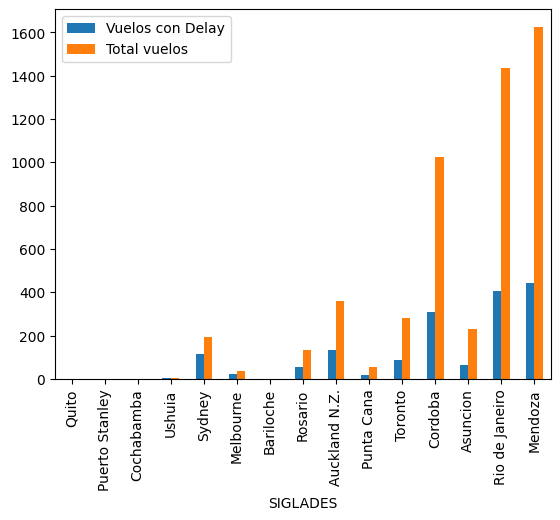

In [23]:
print('Sigla Destino inicial programado versus el delay')
tabla_sigdestino_prog_delay=data_comportamiento.groupby('SIGLADES')['DELAY'].agg(
[('Vuelos con Delay', lambda x: (x == 1).sum()),('Total vuelos', 'count'),('Ratio vuelos con Delay', lambda x: ((x == 1).sum() / x.count())*100)]).sort_values(by=['Ratio vuelos con Delay'], ascending=False).iloc[:15]
print(tabla_sigdestino_prog_delay)
tabla_sigdestino_prog_delay.plot(kind="bar",y=['Vuelos con Delay','Total vuelos'] ,stacked=False)

Codigo del Destino inicial programado versus el delay
       Vuelos con Delay  Total vuelos  Ratio vuelos con Delay
Des-I                                                        
EGYP                  1             1              100.000000
SLCB                  1             1              100.000000
SEQU                  1             1              100.000000
SEQM                  1             1              100.000000
SAWH                  4             6               66.666667
YSSY                113           195               57.948718
YMML                 21            38               55.263158
SAZS                  1             2               50.000000
SAAR                 54           136               39.705882
NZAA                135           361               37.396122
MDPC                 18            54               33.333333
CYYZ                 89           283               31.448763
SACO                308          1023               30.107527
SGAS            

<AxesSubplot: xlabel='Des-I'>

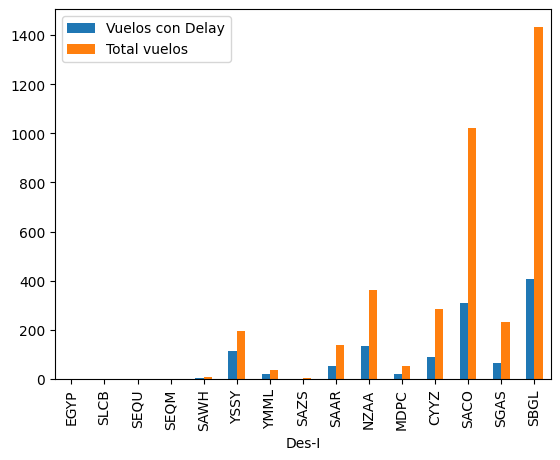

In [24]:
print('Codigo del Destino inicial programado versus el delay')
tabla_destino_prog_delay=data_comportamiento.groupby('Des-I')['DELAY'].agg(
[('Vuelos con Delay', lambda x: (x == 1).sum()),('Total vuelos', 'count'),('Ratio vuelos con Delay', lambda x: ((x == 1).sum() / x.count())*100)]).sort_values(by=['Ratio vuelos con Delay'], ascending=False).iloc[:15]
print(tabla_destino_prog_delay)
tabla_destino_prog_delay.plot(kind="bar",y=['Vuelos con Delay','Total vuelos'] ,stacked=False)

Mes del año versus el delay
     Vuelos con Delay  Total vuelos  Ratio vuelos con Delay
MES                                                        
7                1758          5992               29.339119
12               1615          6356               25.409062
10               1363          6032               22.596154
11               1199          6080               19.720395
8                 996          5744               17.339833
9                 967          5610               17.237077
6                 852          4981               17.104999
1                 978          6108               16.011788
5                 827          5240               15.782443
2                 843          5561               15.159144
4                 585          5020               11.653386
3                 631          5482               11.510398


<AxesSubplot: xlabel='MES'>

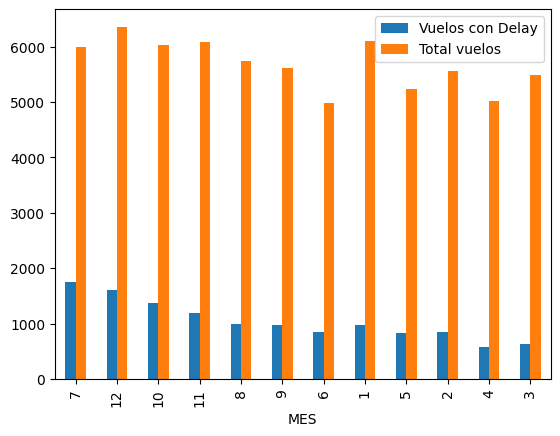

In [25]:
print('Mes del año versus el delay')
tabla_mes_delay=data_comportamiento.groupby('MES')['DELAY'].agg(
[('Vuelos con Delay', lambda x: (x == 1).sum()),('Total vuelos', 'count'),('Ratio vuelos con Delay', lambda x: ((x == 1).sum() / x.count())*100)]).sort_values(by=['Ratio vuelos con Delay'], ascending=False).iloc[:12]
print(tabla_mes_delay)
tabla_mes_delay.plot(kind="bar",y=['Vuelos con Delay','Total vuelos'] ,stacked=False)

Dia de la semana versus el delay
           Vuelos con Delay  Total vuelos  Ratio vuelos con Delay
DIANOM                                                           
Viernes                2285         10292               22.201710
Lunes                  2048         10131               20.215181
Jueves                 2045         10251               19.949273
Miercoles              1661          9722               17.084962
Martes                 1634          9662               16.911613
Sabado                 1363          8352               16.319444
Domingo                1578          9796               16.108616


<AxesSubplot: xlabel='DIANOM'>

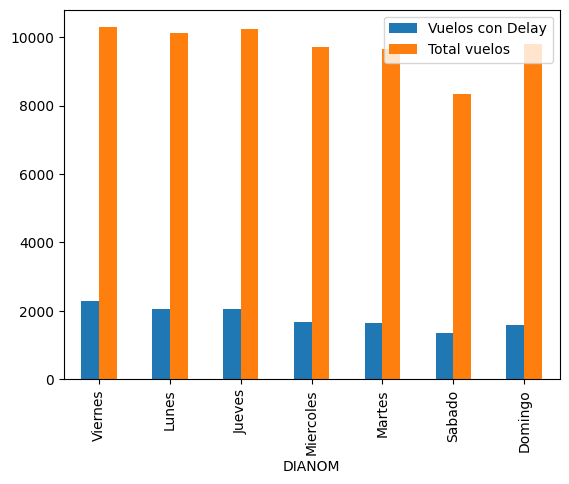

In [26]:
print('Dia de la semana versus el delay')
tabla_dianom_delay=data_comportamiento.groupby('DIANOM')['DELAY'].agg(
[('Vuelos con Delay', lambda x: (x == 1).sum()),('Total vuelos', 'count'),('Ratio vuelos con Delay', lambda x: ((x == 1).sum() / x.count())*100)]).sort_values(by=['Ratio vuelos con Delay'], ascending=False).iloc[:7]
print(tabla_dianom_delay)
tabla_dianom_delay.plot(kind="bar",y=['Vuelos con Delay','Total vuelos'] ,stacked=False)

Tipo de vuelo versus el delay
           Vuelos con Delay  Total vuelos  Ratio vuelos con Delay
TIPOVUELO                                                        
I                      7048         31240               22.560819
N                      5566         36966               15.057079


<AxesSubplot: xlabel='TIPOVUELO'>

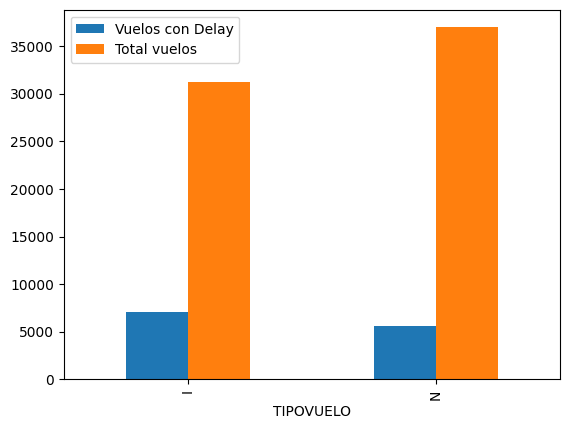

In [27]:
print('Tipo de vuelo versus el delay')
tabla_tipovuelo_delay=data_comportamiento.groupby('TIPOVUELO')['DELAY'].agg(
[('Vuelos con Delay', lambda x: (x == 1).sum()),('Total vuelos', 'count'),('Ratio vuelos con Delay', lambda x: ((x == 1).sum() / x.count())*100)]).sort_values(by=['Ratio vuelos con Delay'], ascending=False).iloc[:2]
print(tabla_tipovuelo_delay)
tabla_tipovuelo_delay.plot(kind="bar",y=['Vuelos con Delay','Total vuelos'] ,stacked=False)

codigo de la Aerolinea que está programado el vuelo versus el delay
       Vuelos con Delay  Total vuelos  Ratio vuelos con Delay
Emp-I                                                        
LNE                   1             1              100.000000
DSM                   2             2              100.000000
LXP                   7             9               77.777778
PUE                  30            49               61.224490
QFU                 113           195               57.948718
LPE                   2             4               50.000000
ACA                 258           565               45.663717
LAW                 642          1574               40.787802
JMR                  39           100               39.000000
GLO                 287           806               35.607940


<AxesSubplot: xlabel='Emp-I'>

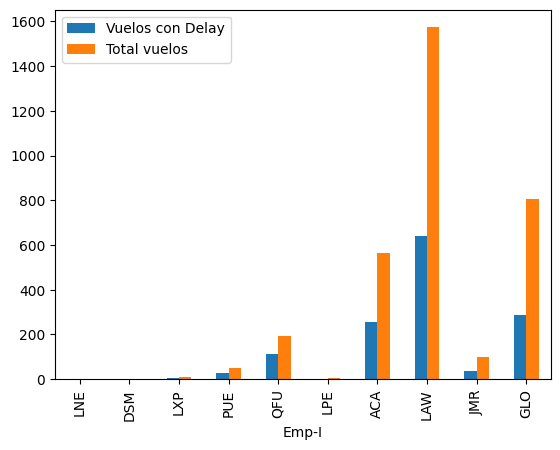

In [28]:
print('codigo de la Aerolinea que está programado el vuelo versus el delay')
tabla_codaeroprog_delay=data_comportamiento.groupby('Emp-I')['DELAY'].agg(
[('Vuelos con Delay', lambda x: (x == 1).sum()),('Total vuelos', 'count'),('Ratio vuelos con Delay', lambda x: ((x == 1).sum() / x.count())*100)]).sort_values(by=['Ratio vuelos con Delay'], ascending=False).iloc[:10]
print(tabla_codaeroprog_delay)
tabla_codaeroprog_delay.plot(kind="bar",y=['Vuelos con Delay','Total vuelos'] ,stacked=False)

Codigo de la Aerolinea que opera el vuelo versus el delay
       Vuelos con Delay  Total vuelos  Ratio vuelos con Delay
Emp-O                                                        
TPU                   2             2              100.000000
56R                  11            17               64.705882
PUE                  30            49               61.224490
QFA                 113           195               57.948718
ACA                 258           565               45.663717
JMR                 668          1647               40.558591
GLO                 287           806               35.607940
DSM                 167           493               33.874239
AVA                 280           885               31.638418
LAP                  62           219               28.310502


<AxesSubplot: xlabel='Emp-O'>

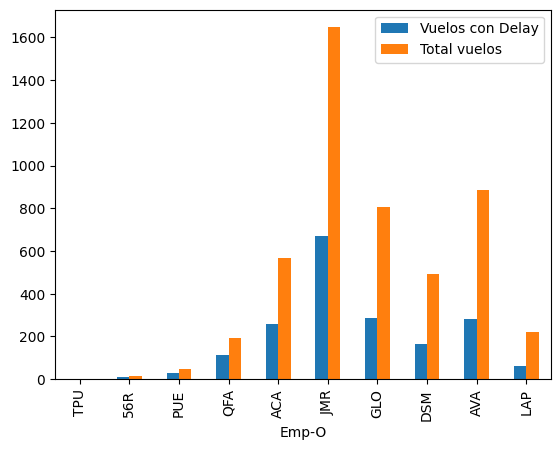

In [29]:
print('Codigo de la Aerolinea que opera el vuelo versus el delay')
tabla_codaeroopera_delay=data_comportamiento.groupby('Emp-O')['DELAY'].agg(
[('Vuelos con Delay', lambda x: (x == 1).sum()),('Total vuelos', 'count'),('Ratio vuelos con Delay', lambda x: ((x == 1).sum() / x.count())*100)]).sort_values(by=['Ratio vuelos con Delay'], ascending=False).iloc[:10]
print(tabla_codaeroopera_delay)
tabla_codaeroopera_delay.plot(kind="bar",y=['Vuelos con Delay','Total vuelos'] ,stacked=False)

Aerolinea que realmente opera el vuelo versus el delay
                          Vuelos con Delay  Total vuelos  \
OPERA                                                      
Plus Ultra Lineas Aereas                30            49   
Qantas Airways                         113           195   
Air Canada                             258           565   
Latin American Wings                   681          1674   
Gol Trans                              287           806   
Avianca                                306          1152   
Aerolineas Argentinas                  468          1949   
Austral                                 15            74   
JetSmart SPA                           196          1095   
Grupo LATAM                           7306         40892   

                          Ratio vuelos con Delay  
OPERA                                             
Plus Ultra Lineas Aereas               61.224490  
Qantas Airways                         57.948718  
Air Canada          

<AxesSubplot: xlabel='OPERA'>

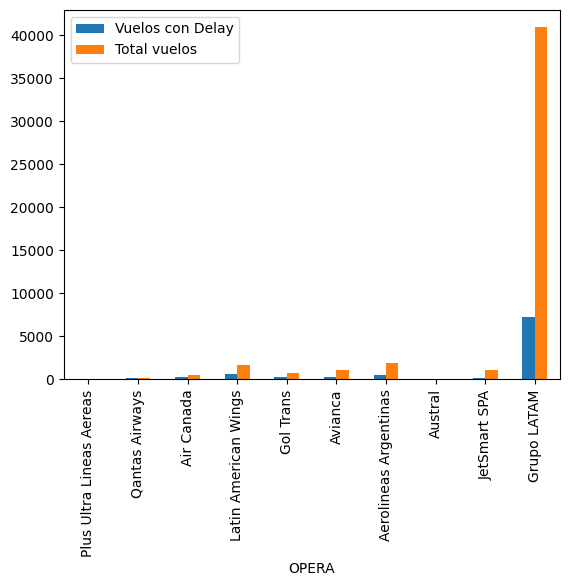

In [30]:
print('Aerolinea que realmente opera el vuelo versus el delay')
tabla_aeroopera_delay=data_comportamiento.groupby('OPERA')['DELAY'].agg(
[('Vuelos con Delay', lambda x: (x == 1).sum()),('Total vuelos', 'count'),('Ratio vuelos con Delay', lambda x: ((x == 1).sum() / x.count())*100)]).sort_values(by=['Ratio vuelos con Delay'], ascending=False).iloc[:10]
print(tabla_aeroopera_delay)

tabla_aeroopera_delay.plot(kind="bar",y=['Vuelos con Delay','Total vuelos'] ,stacked=False)

Temporada en que se realiza el vuelo versus el delay
           Vuelos con Delay  Total vuelos  Ratio vuelos con Delay
TEMPORADA                                                        
1                      4360         22211               19.629913
0                      8254         45995               17.945429


<AxesSubplot: xlabel='TEMPORADA'>

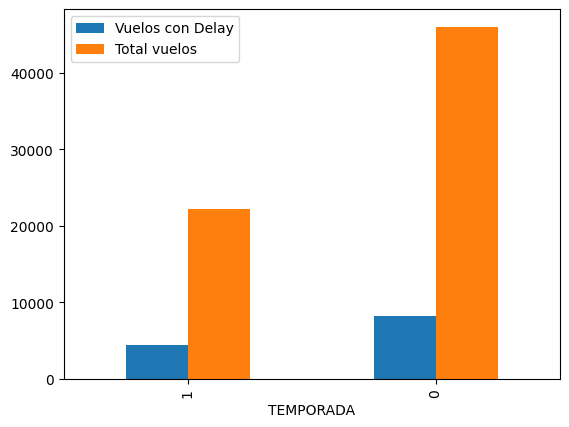

In [31]:
print('Temporada en que se realiza el vuelo versus el delay')
tabla_temporada_delay=data_comportamiento.groupby('TEMPORADA')['DELAY'].agg(
[('Vuelos con Delay', lambda x: (x == 1).sum()),('Total vuelos', 'count'),('Ratio vuelos con Delay', lambda x: ((x == 1).sum() / x.count())*100)]).sort_values(by=['Ratio vuelos con Delay'], ascending=False).iloc[:10]
print(tabla_temporada_delay)

tabla_temporada_delay.plot(kind="bar",y=['Vuelos con Delay','Total vuelos'] ,stacked=False)

El comportamiento de cada una de las variables pedidas se encuentra en la tabla asociada junto con el gráfico. 

Como resultado del análisis se puede ver que:

* Los vuelos Internacionales pese a ser menos que los nacionales presentan un mayor delay. Esto se podría deber a razones externas como el aeropuerto de llegada o problemas con el tráfico aéreo.
* Notar que se tomaron 3 categorías para quien es la aerolinea dado que este valor cambia entre quien opera y quien está programada. Además de agregar la información del nombre completo de la aerolinea utilizando la variable 'OPERA'
* Los 3 días que hay más vuelos dentro del aeropuerto, es decir Lunes-Jueves-Viernes, la tasa de delay es mayor que los otros días. Esto se podría explicar debido a la cantidad de vuelos que operan en el aeropuerto estos días y las dimensiones reales del aeropuerto (posible falla logística de dimensionamiento)

### Variables que más influirían bajo mi criterio visual

En base a mi conocimiento, puedo decir que las variables que más influirían en la predicción de retrasos serían:

* **Mes**: Considerando que el aeropuerto de santiago en invierno sufre problemas con la nubosidad y la posible neblina que pueda existir.
* **Destino** : En base a el mismo punto anterior, si no existen las condiciones climáticas en el destino, entonces no se puede aterrizar y por ende no se puede despegar.
* **Temporada** : Considerando que la tasa de delay aumenta cuando se está en temporada alta por uso del propio aeropuerto. 



# Paso 4: Modelo para determinar el delay

## Agregamos data que podría explicar la información

De la página de MeteoChile https://climatologia.meteochile.gob.cl/application/historico/datosDescarga/330021 se extrajo la bbdd de Temperaturas ,viento y presion para mejorar los resultados.

Se tiene la temperatura en cada hora del año 2017 en grados celsius, la velocidad del viento en nudos y la presión en pascales

De la página rp5.ru https://rp5.ru/Archivo_de_tiempo_en_Santiago_(aeropuerto),_METAR se extrajo igual una BBDD que está dentro de los csv adjuntos.

In [32]:
Temperatura = pd.read_csv("330021_2017_Temperatura_.csv", sep=";")
Viento = pd.read_csv("330021_2017_Viento_.csv", sep= ";")
Presion = pd.read_csv("330021_2017_PresionQFF_.csv", sep= ";")
Nubosidad_visibilidad = pd.read_csv("rp5ru_data.csv", sep= ";")
Nueva_df = pd.read_csv("synthetic_features.csv", low_memory=False)
Temperatura = Temperatura.drop(columns="CodigoNacional")
Viento = Viento.drop(columns='CodigoNacional')
Presion = Presion.drop(columns='CodigoNacional')
Temperatura["momento"] = pd.to_datetime(Temperatura["momento"]).dt.strftime("%Y-%m-%d %H:00:00")
Viento["momento"]= pd.to_datetime(Viento["momento"]).dt.strftime("%Y-%m-%d %H:00:00")
Presion["momento"]= pd.to_datetime(Presion["momento"]).dt.strftime("%Y-%m-%d %H:00:00")
Nubosidad_visibilidad["momento"]= pd.to_datetime(Nubosidad_visibilidad["Hora local en Santiago (aeropuerto)"]).dt.strftime("%Y-%m-%d %H:00:00")
Nubosidad_visibilidad = Nubosidad_visibilidad.drop(columns="Hora local en Santiago (aeropuerto)")


De las bases de datos que tenemos, se procederan a unir cuando las fechas contenidas sean exactamente las mismas, cosa que la información sea verídica para el modelo

Para esto, se calculan las variables con la hora donde estaba programado el vuelo, dado que este fue el que se retrasó por posibles problemas. Se asume ceteris paribus dentro de los 60 minutos.

## Union de la data

In [33]:
Nueva_df["momento"] = pd.to_datetime(Nueva_df["Fecha-I"]).dt.strftime("%Y-%m-%d %H:00:00")
base_Temp_viento = pd.merge(Temperatura,Viento, on= 'momento')
base_Temp_viento_presion = pd.merge(base_Temp_viento,Presion, on= 'momento')
base_Temp_viento_presion_nub_vis = pd.merge(base_Temp_viento_presion,Nubosidad_visibilidad, on= 'momento')
data_TVN = Nueva_df.join(base_Temp_viento_presion_nub_vis.set_index('momento'), on='momento', lsuffix='_left', rsuffix='_right')
Nueva_df = Nueva_df.drop(columns = 'momento')
data_TVN = data_TVN.drop(columns='dd_Valor')
data_TVN = data_TVN.drop(columns='momento')
data_TVN.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68818 entries, 0 to 68205
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Fecha-I              68818 non-null  object 
 1   Vlo-I                68818 non-null  object 
 2   Ori-I                68818 non-null  object 
 3   Des-I                68818 non-null  object 
 4   Emp-I                68818 non-null  object 
 5   Fecha-O              68818 non-null  object 
 6   Vlo-O                68817 non-null  object 
 7   Ori-O                68818 non-null  object 
 8   Des-O                68818 non-null  object 
 9   Emp-O                68818 non-null  object 
 10  DIA                  68818 non-null  int64  
 11  MES                  68818 non-null  int64  
 12  AÑO                  68818 non-null  int64  
 13  DIANOM               68818 non-null  object 
 14  TIPOVUELO            68818 non-null  object 
 15  OPERA                68818 non-null 

Hasta aqui tenemos la base de datos inicial junto con 3 variables más, las cuales son:
* Ts_valor : Temperatura en grados celsius
* ff_Valor : Rapidez del viento en nudos
* VRB_Valor : 1 cuando el viento es variable, 0 cuando es constante en la medición
* QFF_Valor : Presion en Pascales en la estación
* Nubosidad : Descripción del tipo de nubes
* Visibilidad : Metros a los que se puede visualizar en el aeropuerto, notar que los 10 son 10 o más metros.

Se sacó la variable dd_Valor dado que esta contenía valores NaN lo que no ayudaba al modelo de redes neuronales, además de estar correlacionada al 100% con la variable VRB. Dado que cuando la variable dd_Valor era NaN el valor de VRB era 1. 

Notar que todas estas mediciones se realizaron al inicio de cada una de las horas.

## Limpieza de la base de datos - Explicaciones

En primera instancia se contabilizará las veces que el operador del vuelo no es el mismo que debía operar el vuelo. Lo que podría generar un delay.

In [34]:
contador_operador_vuelo = 0
for index,row in data_TVN.iterrows():
    if row['Emp-I'] != row['Emp-O']:
        contador_operador_vuelo += 1
contador_operador_vuelo

18856

Como existen 18.856 casos donde las empresas son diferentes, se tomará una variable que determina si la empresas son la misma o no.

Se considerará una variable binaria del estilo: 
1 si las empresas son distintas, 0 si no

In [35]:
for index,row in data_TVN.iterrows():
    if row['Emp-I'] != row['Emp-O']:
        data_TVN.loc[index,'Empresas_distintas'] = 1
    else:
        data_TVN.loc[index,'Empresas_distintas'] = 0

Dado que pueden existir problemas en los destinos, se evaluará si el destino de salida realizado es igual al destino de salida programado. Esto puede verse afectado por condiciones climáticas en el aterrizaje

In [36]:
contador_destinos = 0
for index,row in data_TVN.iterrows():
    if row['Des-I'] != row['Des-O']:
        contador_destinos += 1
contador_destinos

28

Con el mismo criterio entregado en donde las empresas pueden ser distintas, se utilizará una variable binaria que tomará el valor de 1 cuando el destino operado no sea exactamente igual destino programado y 0 en los otros casos.

In [37]:
for index,row in data_TVN.iterrows():
    if row['Des-I'] != row['Des-O']:
        data_TVN.loc[index,'Destino_distinto'] = 1
    else:
        data_TVN.loc[index,'Destino_distinto'] = 0

Ahora se evaluarán los vuelos que cambiaron el origen y los que cambiaron el número de vuelo.

In [38]:
origen_vuelos = 0
for index,row in data_TVN.iterrows():
    if row['Ori-I'] != row['Ori-O']:
        origen_vuelos += 1
print("la cantidad de vuelos que cambiaron de origen son: " + str(origen_vuelos))
vuelos_cambio_numero = 0
for index,row in data_TVN.iterrows():
    if row['Vlo-I'] != row['Vlo-O']:
        vuelos_cambio_numero += 1
print("la cantidad de vuelos que cambiaron de el número de vuelo son: " + str(vuelos_cambio_numero))

la cantidad de vuelos que cambiaron de origen son: 0
la cantidad de vuelos que cambiaron de el número de vuelo son: 4582


Se eliminarán las variables de los origenes del vuelo, tanto programado como operado dado que estas últimas variables no suman. Esto porque se tiene la información que se tiene es del aeropuerto de santiago y toda la data es del mismo aeropuerto, esto se puede ver en el codigo anterior donde la diferencia entre el aeropuerto original programado con el ejecutado es 0, es decir todos los vuelos que salieron de santiago debían salir de santiago.

Para los cambios de número de vuelo, se tendrá una variable binaria que será 1 cuando haya cambiado el número y 0 cuando siga el mismo número.

In [39]:
data_TVN = data_TVN.drop('Ori-I', axis=1)
data_TVN = data_TVN.drop('Ori-O', axis=1)
for index, row in data_TVN.iterrows():
    if row['Vlo-I'] != row['Vlo-O']:
        data_TVN.at[index, 'Numero_vuelo_distinto'] = 1
    else:
        data_TVN.at[index, 'Numero_vuelo_distinto'] = 0
data_TVN = data_TVN.drop('Vlo-I', axis=1)
data_TVN = data_TVN.drop('Vlo-O', axis=1)

Se limpiarán los valores que no aportan para el estudio, como la sigla del origen y el año. Dado que los dos valores son constantes.

In [40]:
data_TVN = data_TVN.drop('SIGLAORI', axis=1)
data_TVN = data_TVN.drop('AÑO', axis=1)

Las variables de fecha se sacarán del modelo dado que estas están desagregadas en las variables Period Day, DIA y MES. Además el valor de Diferencia en minutos no sirve para pronosticar dado que este es un resultado y se busca pronosticar sobre el mismo. En caso de incluirlo, el resto de las variables no tendrían sentido dado que la correlación entre la diferencia en minutos y el delay es de 1 por como se definió la variable DELAY.

In [41]:
data_TVN = data_TVN.drop('Fecha-I', axis=1)
data_TVN = data_TVN.drop('DiferenciaEnMinutos', axis=1)
data_TVN = data_TVN.drop('Fecha-O', axis=1)

In [42]:
print(data_TVN.isna().sum())

Des-I                       0
Emp-I                       0
Des-O                       0
Emp-O                       0
DIA                         0
MES                         0
DIANOM                      0
TIPOVUELO                   0
OPERA                       0
SIGLADES                    0
TEMPORADA                   0
DELAY                       0
Period Day                  0
Ts_valor                 1623
ff_Valor                 1623
VRB_Valor                1623
QFF_Valor                1634
Nubosidad                1732
Visibilidad              1816
Empresas_distintas          0
Destino_distinto            0
Numero_vuelo_distinto       0
dtype: int64


Se puede ver que 1816 valores no tienen data de la nubosidad, por ende se borrarán para tener información más detallada del pronóstico. Se calculará el número de vuelos con delay.

In [43]:
data_TVN = data_TVN.dropna()

print(data_cambiable['DELAY'].value_counts())

print(data_TVN['DELAY'].value_counts())

0    55592
1    12614
Name: DELAY, dtype: int64
0    54525
1    12357
Name: DELAY, dtype: int64


Al realizar este cambio, pasamos a tener 66.882 informaciones de data, manteniendo un % de data con delay de 18,4%. 

Considerando que entre 2 empresas se tiene la mayoría de los vuelos, se tomarán estas 2 empresas y el resto se unirá en una variable otros para la variable 'OPERA'

In [44]:
for index, row in data_TVN.iterrows():
    if row['OPERA'] == 'Grupo LATAM':
        data_TVN.loc[index, 'OPERA'] = 'GLATAM'
    elif row['OPERA'] == 'Sky Airline':
        data_TVN.loc[index, 'OPERA'] = 'SKY'
    else:
        data_TVN.loc[index, 'OPERA'] = 'OTROS'

Se considera que las variables DIA y MES se encuentran dentro de la variable de temporalidad junto con DIANOM. Por ende, se sacarán de la base.

In [45]:
data_TVN = data_TVN.drop('DIA', axis=1)
data_TVN = data_TVN.drop('MES', axis=1)

## Transformar variables categoricas en variables binarias para tener el data set para los modelos

In [46]:
Data_Delay = data_TVN['DELAY']
variables_a_binarias = ['Des-I', 'Emp-I', 'Des-O', 'Emp-O','DIANOM','TIPOVUELO', 'OPERA', 'SIGLADES','Period Day','Nubosidad']
variables_mantener = [ 'TEMPORADA','Ts_valor', 'ff_Valor', 'VRB_Valor', 'QFF_Valor','Visibilidad', 'Empresas_distintas', 'Destino_distinto','Numero_vuelo_distinto'] 
data_modelos = pd.DataFrame()

for dato in variables_a_binarias:
    datos_a_agregar = pd.get_dummies(data_TVN[dato], drop_first=True, prefix=dato)
    data_modelos = pd.concat([data_modelos, datos_a_agregar], axis=1)

for dato_mant in variables_mantener:
    datos_a_agregar = data_TVN[dato_mant]
    data_modelos = pd.concat([data_modelos, datos_a_agregar], axis=1)    

data_modelos['Empresas_distintas'] = data_modelos['Empresas_distintas'].astype(int)
data_modelos['Destino_distinto'] = data_modelos['Destino_distinto'].astype(int)
data_modelos['Numero_vuelo_distinto'] = data_modelos['Numero_vuelo_distinto'].astype(int)

data_modelos.columns

Index(['Des-I_EGLL', 'Des-I_EGYP', 'Des-I_KATL', 'Des-I_KDFW', 'Des-I_KIAH',
       'Des-I_KJFK', 'Des-I_KLAX', 'Des-I_KMCO', 'Des-I_KMIA', 'Des-I_LEMD',
       ...
       'Nubosidad_Nubosidad fragmentada', 'TEMPORADA', 'Ts_valor', 'ff_Valor',
       'VRB_Valor', 'QFF_Valor', 'Visibilidad', 'Empresas_distintas',
       'Destino_distinto', 'Numero_vuelo_distinto'],
      dtype='object', length=270)

Se pasaron las variables categóricas a variables binarias debido a que de esta forma los algoritmos. Dado que si se daban variables del tipo categóricas, el modelo podía creer que existía una componente entera dada la cantidad de variables.

* Se verificará la correlación entre las variables que tiene el modelo versus la variable respuesta o DELAY. 

* Esto se hará netamente con fines de ver las relaciones entre las variables. Esperando que el modelo seleccione por si solo las variable que realmente va a ocupar.

In [47]:
data_correlaciones = pd.concat([data_modelos,Data_Delay], axis=1)
correlations = data_correlaciones.corrwith(data_correlaciones['DELAY'])
significant_vars = correlations[abs(correlations) > 0.03].index.tolist()

print("Son ",len(significant_vars)," variables \n")
print(significant_vars)

Son  61  variables 

['Des-I_MPTO', 'Des-I_NZAA', 'Des-I_SABE', 'Des-I_SACO', 'Des-I_SAEZ', 'Des-I_SAME', 'Des-I_SBGL', 'Des-I_SBGR', 'Des-I_SCCF', 'Des-I_SCFA', 'Des-I_SKBO', 'Des-I_SPJC', 'Des-I_YSSY', 'Emp-I_ACA', 'Emp-I_CMP', 'Emp-I_GLO', 'Emp-I_LAN', 'Emp-I_LAW', 'Emp-I_QFU', 'Emp-I_TAM', 'Des-O_MPTO', 'Des-O_NZAA', 'Des-O_SABE', 'Des-O_SACO', 'Des-O_SAEZ', 'Des-O_SAME', 'Des-O_SBGL', 'Des-O_SBGR', 'Des-O_SCCF', 'Des-O_SCFA', 'Des-O_SKBO', 'Des-O_SPJC', 'Des-O_YSSY', 'Emp-O_AAL', 'Emp-O_ACA', 'Emp-O_AVA', 'Emp-O_CMP', 'Emp-O_DSM', 'Emp-O_GLO', 'Emp-O_JMR', 'Emp-O_LXP', 'Emp-O_QFA', 'Emp-O_TAM', 'DIANOM_Viernes', 'TIPOVUELO_N', 'OPERA_OTROS', 'SIGLADES_Auckland N.Z.', 'SIGLADES_Bogota', 'SIGLADES_Buenos Aires', 'SIGLADES_Calama', 'SIGLADES_Ciudad de Panama', 'SIGLADES_Cordoba', 'SIGLADES_Lima', 'SIGLADES_Mendoza', 'SIGLADES_Rio de Janeiro', 'SIGLADES_Sao Paulo', 'SIGLADES_Sydney', 'Period Day_morning', 'ff_Valor', 'Numero_vuelo_distinto', 'DELAY']


Esta prueba, nos dice que con 60 variables, dado que se debe omitir la correlación DELAY-DELAY, podemos explicar la mayoría del comportamiento del DELAY. Notar que en un principio eran 270.

## División de la Data en Entrenamiento y Testeo

Para los modelos, se utilizará el set de datos de data_modelos como datos de entrada y Data_Delay como salida.

### División para el set de datos

Se tomará un 10% de la data para testeo. 

In [48]:
x_train, x_test, y_train, y_test = train_test_split(data_modelos, Data_Delay, test_size = 0.1, random_state = 42)

In [49]:
x_train.shape, x_test.shape

((60193, 270), (6689, 270))

In [50]:
y_train.value_counts('%')

0    0.814929
1    0.185071
Name: DELAY, dtype: float64

In [51]:
y_test.value_counts('%')

0    0.81806
1    0.18194
Name: DELAY, dtype: float64

## Modelos

### Regresión logística

In [52]:
modelo_reg = LogisticRegression(class_weight='balanced',random_state=42,max_iter=1000000)
modelo_reg.fit(x_train,y_train)
ref_pred = modelo_reg.predict(x_test)
print(classification_report(y_test,ref_pred))
score_RL = modelo_reg.score(x_test, y_test) 
print(score_RL)

              precision    recall  f1-score   support

           0       0.87      0.66      0.75      5472
           1       0.27      0.57      0.37      1217

    accuracy                           0.64      6689
   macro avg       0.57      0.61      0.56      6689
weighted avg       0.76      0.64      0.68      6689

0.6438929585887277


In [53]:
cm = confusion_matrix(y_test, ref_pred)
tn, fp, fn, tp = cm.ravel()
print("True Negative (TN):", tn)
print("False Positive (FP):", fp)
print("False Negative (FN):", fn)
print("True Positive (TP):", tp)
Ac = ((tp+tn)/(tn+tp+fp+fn))
print("Accuracy (Ac):", Ac)

True Negative (TN): 3616
False Positive (FP): 1856
False Negative (FN): 526
True Positive (TP): 691
Accuracy (Ac): 0.6438929585887277


### XGBoost

In [54]:
model_xgboost = xgb.XGBClassifier(objective='binary:logistic',eval_metric='auc')
model_xgboost.fit(x_train, y_train)
pred_xgboost = model_xgboost.predict(x_test)
print(classification_report(y_test, pred_xgboost))
score_XGB = model_xgboost.score(x_test, y_test) 
print(score_XGB)

              precision    recall  f1-score   support

           0       0.83      0.99      0.90      5472
           1       0.64      0.12      0.20      1217

    accuracy                           0.83      6689
   macro avg       0.74      0.55      0.55      6689
weighted avg       0.80      0.83      0.78      6689

0.8276274480490358


In [55]:
cm = confusion_matrix(y_test,pred_xgboost )
tn, fp, fn, tp = cm.ravel()
print("True Negative (TN):", tn)
print("False Positive (FP):", fp)
print("False Negative (FN):", fn)
print("True Positive (TP):", tp)
Ac = ((tp+tn)/(tn+tp+fp+fn))
print("Accuracy (Ac):", Ac)

True Negative (TN): 5392
False Positive (FP): 80
False Negative (FN): 1073
True Positive (TP): 144
Accuracy (Ac): 0.8276274480490358


### Decision Tree

In [56]:
decision_tree = DecisionTreeClassifier(max_depth=5)
decision_tree.fit(x_train,y_train)
score_DT = decision_tree.score(x_test, y_test) 
y_pred_dt = decision_tree.predict(x_test)
print(classification_report(y_test, y_pred_dt))
print(score_DT)

              precision    recall  f1-score   support

           0       0.83      0.99      0.90      5472
           1       0.64      0.06      0.10      1217

    accuracy                           0.82      6689
   macro avg       0.73      0.52      0.50      6689
weighted avg       0.79      0.82      0.76      6689

0.8223949768276274


In [57]:
cm = confusion_matrix(y_test,y_pred_dt)
tn, fp, fn, tp = cm.ravel()
print("True Negative (TN):", tn)
print("False Positive (FP):", fp)
print("False Negative (FN):", fn)
print("True Positive (TP):", tp)
Ac = ((tp+tn)/(tn+tp+fp+fn))
print("Accuracy (Ac):", Ac)

True Negative (TN): 5434
False Positive (FP): 38
False Negative (FN): 1150
True Positive (TP): 67
Accuracy (Ac): 0.8223949768276274


# Paso 5: Evaluar la performance del modelo

Considerando los 3 modelos expuestos, se evaluará dependiendo de los valores del recall y el accuracy

* El modelo de Regresión logística tiene un recall de 0,57 y un accuracy de 0.6438
* El modelo de XGBoost tiene un recall de 0,12 y un accuracy de 0.8276
* El modelo de Decision Tree tiene un recall de 0,06 y un accuracy de 0.8224

En este sentido, se deben observar 2 medidas para evaluar el rendimiento del modelo, esto debido a que cada uno por si solo puede llegar a estar cesgado, además que la precisión es comparar el modelo planteado versus si mismo. Por esta razón, se tomaron estas dos metricas, donde se deben mirar los 2 valores por separado en primera instancia y luego en su conjunto.

En ese sentido, el modelo que mejor tiene un Accuracy es el modelo de XGBoost con 0.8276 , lo que implica que del total de muestras de testeo el modelo predijo de buena forma la suma del caso positivo y negativo sobre el total de datos que predijo. 

Por otra parte, tenemos que el modelo de regresión logística tiene un recall de 0,57 en la existencia de DELAY en el vuelo. Esto quiere decir que del total de casos que realmente tuvieron delay, respondió de buena manera en un 57% de las veces.

Por estas 2 razones, me quedo con el modelo de Regresión logística, dado que es el modelo que más me ayuda a hacer lo que le estoy pidiendo al modelo, que es predecir la existencia de delay en un vuelo.

In [58]:
coeficientes = modelo_reg.coef_[0]
nombres_variables = x_train.columns.tolist()
idx_coeficientes = np.argsort(abs(coeficientes))[::-1]
nombres_variables_influyentes = [nombres_variables[i] for i in idx_coeficientes[:10]]
print(nombres_variables_influyentes)

['Emp-O_JMR', 'Numero_vuelo_distinto', 'Emp-O_ACA', 'Emp-I_ACA', 'Emp-O_AAL', 'Emp-I_LAW', 'Emp-O_GLO', 'Emp-I_GLO', 'Empresas_distintas', 'DIANOM_Viernes']


Con el codigo anterior se puede ver que del modelo elegido las 10 variables elegidas más influyentes son empresas, tanto programadas como las que operan el vuelo junto a si el vuelo cambió de número, si la empresa que tenía el vuelo cambió en algún momento y si el día era viernes.

Como era de esperarse, se tiene que si se cambia el número del vuelo esto ocasiona un DELAY en el aeropuerto dado que se deben configurar diferentes plataformas nuevamente, y es engorroso para el cliente final que aborda el vuelo. Ocurre algo parecido con las empresas distintas, dado que no necesariamente existe una comunicación efectiva entre estas ocasionando problemas en la logística del aeropuerto.

Notar que al comparar estas 10 variables con las correlaciones sacadas anteriormente donde están ordenadas de menor a mayor que cumplan con la condición de que el valor absoluto sea mayor a 0.03, hay variables como la velocidad del viento o ff_Valor que no están dentro del modelo.

Para poder mejorar la performance del modelo, se puede entregar un set de datos más balanceado o entrar de forma más exhaustiva en los cambios de parámetros de los modelos. Otras forma de mejorar la respuesta del modelo sería encontrar la data de cada una de las ciudades de destino en el momento que tuvo que haber llegado, es decir un predicción de como estaría el destino cuando tuvo que aterrizar. Esta variable podría servir para determinar si los delay en el aeropuerto son ocasionadas por problemas internos o de la aerolinea o por problemas externos como climáticos. 

No se incluyó esta variable debido a que la cantidad de destinos a los que se podía ir era del orden de 62 ciudades, donde no necesariamente está la data guardada historica. Otra variable importante sería ver si un vuelo se atraso, el siguiente igual se atrasa, es decir si por efecto "dominó" el vuelo siguiente parte atrasado y asi con todos los demás. Para esto se podría generar una variable del tipo binaria que diga si el vuelo anterior tuvo un delay o no y otra de cuanto fue el delay.

En este sentido, se debe mirar el predictor con "pinzas" dado que la tasa de error del predictor es alta, aproximadamente de un 38% pero cuando acierta al valor que existe un delay, hay más probabilidades que asi sea versus los otros modelos.

Teniendo toda esta información, tampoco se puede asegurar que el modelo mejore en una cuantía significativa. Pero con esta data, se podría generar un mejor modelo que sea más fiable y más robusto.